<a href="https://colab.research.google.com/github/ko-i/study/blob/main/tensorflow2/code47.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.LSTM(128))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.GRU(256, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None, ))
encoder_embedding = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(encoder_input)

output, state_h, state_c = layers.LSTM(64, return_state=True, name='encoder')(encoder_embedding)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None, ))
decoder_embedding = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

decoder_output = layers.LSTM(64, name='decoder')(decoder_embedding, initial_state=encoder_state)
output = layers.Dense(10)(decoder_output)

model = keras.Model(inputs=[encoder_input, decoder_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

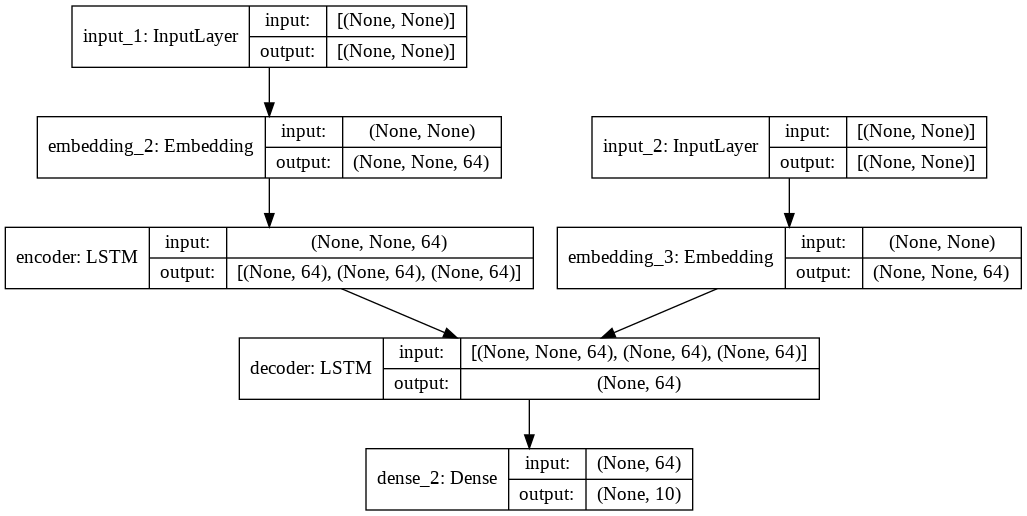

In [5]:
keras.utils.plot_model(model, show_shapes=True)

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

lstm_layer.reset_states()

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
exist_states = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=exist_states)

In [8]:
model = keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True) , input_shape=(5, 10)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 64
input_dim = 28
units = 64
output_size = 10

def build_model(allow_cudnn_kernel=True):
    if allow_cudnn_kernel:
        lstm_layer = layers.LSTM(units, input_shape=(None, input_dim))
    else:
        lstm_layer = layers.RNN(layers.LSTMCell(units), input_shape=(None, input_dim))
    
    model = keras.models.Sequential([
        lstm_layer,
        layers.BatchNormalization(),
        layers.Dense(output_size)
    ])

    return model

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

sample, sample_label = x_train[0], y_train[0]

11493376/11490434 [==============================] - 0s 0us/step


In [11]:
model = build_model(True)
model.compile(optimizer='sgd', loss=keras.losses.SparseCategoricalCrossentropy(True), metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1)

938/938 [==============================] - 21s 20ms/step - loss: 0.9822 - accuracy: 0.6912 - val_loss: 0.5461 - val_accuracy: 0.8274


In [12]:
model = build_model(False)
model.compile(optimizer='sgd', loss=keras.losses.SparseCategoricalCrossentropy(True), metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1)

938/938 [==============================] - 19s 19ms/step - loss: 0.9866 - accuracy: 0.6895 - val_loss: 0.5499 - val_accuracy: 0.8271


Predicted label: [3], True label: 5


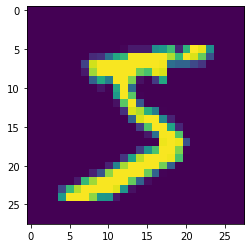

In [13]:
import matplotlib.pyplot as plt

with tf.device('CPU:0'):
    cpu_model = build_model(True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print('Predicted label: {}, True label: {}'.format(result.numpy(), sample_label))
    plt.imshow(sample)

In [14]:
class NestedCell(layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        super(NestedCell, self).__init__(**kwargs)
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
    
    def build(self, input_shapes):
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(shape=(i1, self.unit_1), initializer='uniform', name='kernel_1')
        self.kernel_2_3 = self.add_weight(shape=(i2, i3, self.unit_2, self.unit_3), initializer='uniform', name='kernel_2_3')
    
    def call(self, inputs, states):
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum('bij,ijkl->bkl', input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states
    
    def get_config(self):
        return {'unit_1': self.unit_1, 'unit_2': self.unit_2, 'unit_3': self.unit_3}

In [19]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batchs = 10
time_step = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.Model([input_1, input_2], outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [20]:
input_1_data = np.random.random((batch_size * num_batchs, time_step, i1))
input_2_data = np.random.random((batch_size * num_batchs, time_step, i2, i3))

target_1_data = np.random.random((batch_size * num_batchs, unit_1))
target_2_data = np.random.random((batch_size * num_batchs, unit_2, unit_3))

input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 6s 552ms/step - loss: 0.7620 - rnn_3_loss: 0.2911 - rnn_3_1_loss: 0.4709 - rnn_3_mae: 0.4570 - rnn_3_1_mae: 0.5499
